<a href="https://colab.research.google.com/github/hshang315/Ocelot-collab/blob/master/ANL_hyper_training_Oct1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ANL hyper parameters training from archive - OCT



# import

In [1]:
#%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import time
import seaborn as sns
import os
import h5py as h5
import pickle 

from sklearn.preprocessing import MinMaxScaler
# plt.style.use('ggplot')

qe= 1.60217662*pow(10, -7) # [pC]

# enlarge fonts
plt.rcParams.update({'font.size': 16})

# import matplotlib
# font = {'family' : 'normal',
# #         'weight' : 'bold',
#         'size'   : 14}
# matplotlib.rc('font', **font)
print(tf.__version__)

1.15.0


In [0]:
# Helper functions
def width_calc(Parabola_vals,keyplt):
    sig_p=[]
    for t in Parabola_vals.keys():
        if np.isnan(Parabola_vals.loc[keyplt,t]).all():
            sig_p=np.append(sig_p,float('NaN'))
        else:
            sigi=float(Parabola_vals.loc[keyplt,t][4])
            sig_p=np.append(sig_p, sigi)
    return sig_p

def Xp_calc(Parabola_vals,keyplt):
    Xp=[]
    for t in Parabola_vals.keys():
        if np.isnan(Parabola_vals.loc[keyplt,t]).all():
            Xp=np.append(Xp,float('NaN'))
        else:
            tmp=float(Parabola_vals.loc[keyplt,t][3])
            Xp=np.append(Xp, tmp)
    return Xp

def func(x,Parabola_vals):
    par_tot=[]
    for i in range(len(Parabola_vals.keys())):
        if np.isnan(Parabola_vals.loc[keyplt,t]).all():
            par_tot += [np.array([float('NaN')])] 
        else:
            a0=Parabola_vals[ts[i]][0]
            a1=Parabola_vals[ts[i]][1]
            a2=Parabola_vals[ts[i]][2]
            xp=-Parabola_vals[ts[i]][3]
            par_tot += [a0+a1*(x)+a2*(x)**2]
#             par_tot += [a0+a1*(x-xp)+a2*(x-xp)**2] #[a0+a1*(x)+a2*(x)**2]
    return par_tot


def count_unique(keys):
    uniq_keys = np.unique(keys)
    bins = uniq_keys.searchsorted(keys)
    return uniq_keys, np.bincount(bins) #bincount - Count number of occurrences of each value in uniq_keys


  
def save_obj(str_name,var):
    filehandler = open('GP/Results/01_2018_data_results/'+str_name+'.pkl', 'wb')
    pickle.dump(var, filehandler)
    filehandler.close()

# Read data

In [2]:
#file='/content/scanData-2019-1026.nosteering.xls'
file='/content/scan-opt-all.xls'
file='/content/opt-2019-1111.xls'
#x00 = pd.read_excel(file,skiprows=7)
x00 =pd.read_excel(file,skiprows=12)
#x0 = x00.drop( columns = ['Time','L1:SC3:HZ:CurrentAO', 'L1:SC3:VL:CurrentAO','L1:SC4:HZ:CurrentAO', 'L1:SC4:VL:CurrentAO'], axis=1)
x0 =x00
x0



,Time,L3:CM1:measCurrentCM,L1:RG2:QM1:CurrentAO,L1:RG2:QM2:CurrentAO,L1:RG2:QM3:CurrentAO,L1:RG2:QM4:CurrentAO,L1:QM3:CurrentAO,L1:QM4:CurrentAO,L1:RG2:SC1:VL:CurrentAO,L1:RG2:SC2:HZ:CurrentAO,L1:RG2:SC2:VL:CurrentAO,L1:RG2:SC3:HZ:CurrentAO,L1:RG2:SC3:VL:CurrentAO,L1:SC3:HZ:CurrentAO,L1:SC3:VL:CurrentAO,L1:QM5:CurrentAO,L1:SC4:HZ:CurrentAO,L1:SC4:VL:CurrentAO
0,1573452032,1.104216,1.454024,-1.064716,0.49209,1.437271,0.691982,-0.059893,-0.002471,1.823891,0.140246,0.885964,0.450493,0.101124,0.030465,-0.134298,0.576134,0.280863
1,1573452036,1.104216,1.454024,-1.064716,0.49209,1.437271,0.691982,-0.059893,-0.002471,1.823891,0.140246,0.885964,0.450493,0.101765,0.030465,-0.134298,0.576382,0.280863
2,1573452040,1.104216,1.454024,-1.064716,0.49209,1.437271,0.691982,-0.059893,-0.002471,1.823891,0.140246,0.885964,0.450493,0.101765,0.031476,-0.134298,0.576382,0.280710
3,1573452044,1.098954,1.454024,-1.064716,0.49209,1.437271,0.691982,-0.059893,-0.002471,1.823891,0.140246,0.885964,0.450493,0.101140,0.027735,-0.134298,0.577031,0.279866
4,1573452152,1.104216,1.454024,-1.064716,0.49209,1.437271,0.691982,-0.059893,-0.002471,1.823891,0.140246,0.885964,0.450493,0.101140,0.027735,-0.134298,0.577031,0.279866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4174,1573518468,1.088429,1.454024,-1.064716,0.49209,1.437271,0.691982,-0.059893,-0.002471,1.823891,0.140246,0.885964,0.450493,0.176717,0.013992,-0.134298,0.638860,0.296744
4175,1573518476,1.088429,1.454024,-1.064716,0.49209,1.437271,0.691982,-0.059893,-0.002471,1.823891,0.140246,0.885964,0.450493,0.176621,0.014214,-0.134298,0.639115,0.296982
4176,1573518480,1.083166,1.454024,-1.064716,0.49209,1.437271,0.691982,-0.059893,-0.002471,1.823891,0.140246,0.885964,0.450493,0.176621,0.014214,-0.134298,0.639115,0.296982
4177,1573518484,1.083166,1.454024,-1.064716,0.49209,1.437271,0.691982,-0.059893,-0.002471,1.823891,0.140246,0.885964,0.450493,0.176664,0.015085,-0.134298,0.639595,0.297118


In [3]:
x0.keys()

Index(['Time', 'L3:CM1:measCurrentCM', 'L1:RG2:QM1:CurrentAO',
       'L1:RG2:QM2:CurrentAO', 'L1:RG2:QM3:CurrentAO', 'L1:RG2:QM4:CurrentAO',
       'L1:QM3:CurrentAO', 'L1:QM4:CurrentAO', 'L1:RG2:SC1:VL:CurrentAO',
       'L1:RG2:SC2:HZ:CurrentAO', 'L1:RG2:SC2:VL:CurrentAO',
       'L1:RG2:SC3:HZ:CurrentAO', 'L1:RG2:SC3:VL:CurrentAO',
       'L1:SC3:HZ:CurrentAO', 'L1:SC3:VL:CurrentAO', 'L1:QM5:CurrentAO',
       'L1:SC4:HZ:CurrentAO', 'L1:SC4:VL:CurrentAO'],
      dtype='object')

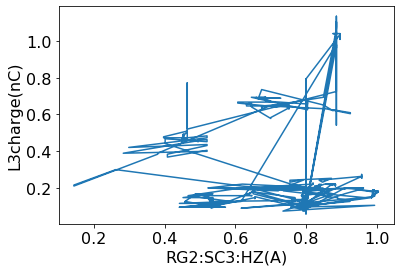

In [4]:
plt.plot(x0['L1:RG2:SC3:HZ:CurrentAO'],x0['L3:CM1:measCurrentCM']);plt.xlabel('RG2:SC3:HZ(A)');plt.ylabel('L3charge(nC)');

 Y.shape= (4179,)
 X.shape= (4179, 16)
Index(['L1:RG2:QM1:CurrentAO', 'L1:RG2:QM2:CurrentAO', 'L1:RG2:QM3:CurrentAO',
       'L1:RG2:QM4:CurrentAO', 'L1:QM3:CurrentAO', 'L1:QM4:CurrentAO',
       'L1:RG2:SC1:VL:CurrentAO', 'L1:RG2:SC2:HZ:CurrentAO',
       'L1:RG2:SC2:VL:CurrentAO', 'L1:RG2:SC3:HZ:CurrentAO',
       'L1:RG2:SC3:VL:CurrentAO', 'L1:SC3:HZ:CurrentAO', 'L1:SC3:VL:CurrentAO',
       'L1:QM5:CurrentAO', 'L1:SC4:HZ:CurrentAO', 'L1:SC4:VL:CurrentAO'],
      dtype='object')


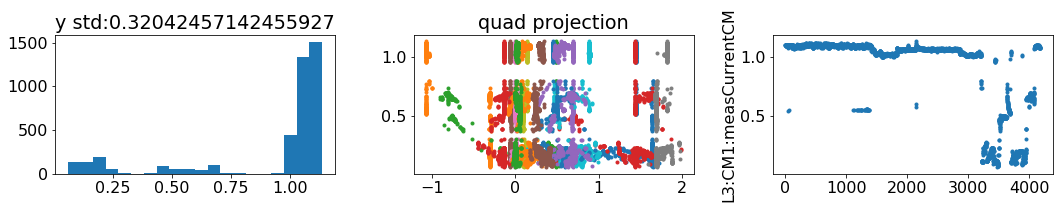

In [7]:
#x0 =pd.read_excel('opt-2019-1014.xls')
x0
X=x0.iloc[:,2:]
objective = 'L3:CM1:measCurrentCM'
Y=x0[objective]

objective = 'L3:CM1:measCurrentCM'
Y=x0[objective]
print(' Y.shape=',Y.shape)
print(' X.shape=',X.shape)
print(X.keys())
plt.figure(figsize=(15,3))
plt.subplot(133); plt.plot(Y,'.'); plt.ylabel(objective)
plt.subplot(131);  plt.hist(Y,20); plt.title('y std:'+ str(Y.std()));
plt.subplot(132);  plt.plot(X,Y,'.'); plt.title('quad projection');
plt.tight_layout()

Text(0, 0.5, 'L3 charge (nC)')

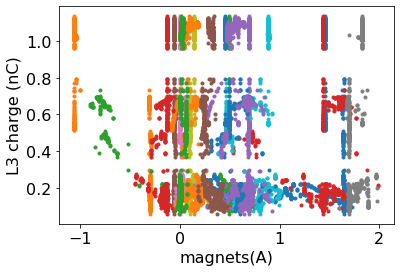

In [8]:
plt.plot(X,Y,'.');plt.xlabel('magnets(A)');plt.ylabel('L3 charge (nC)')


In [9]:
print(X.std())

L1:RG2:QM1:CurrentAO       0.105130
L1:RG2:QM2:CurrentAO       0.297438
L1:RG2:QM3:CurrentAO       0.312212
L1:RG2:QM4:CurrentAO       0.154234
L1:QM3:CurrentAO           0.003649
L1:QM4:CurrentAO           0.004020
L1:RG2:SC1:VL:CurrentAO    0.011663
L1:RG2:SC2:HZ:CurrentAO    0.050730
L1:RG2:SC2:VL:CurrentAO    0.016639
L1:RG2:SC3:HZ:CurrentAO    0.107435
L1:RG2:SC3:VL:CurrentAO    0.068461
L1:SC3:HZ:CurrentAO        0.049334
L1:SC3:VL:CurrentAO        0.014016
L1:QM5:CurrentAO           0.033368
L1:SC4:HZ:CurrentAO        0.084264
L1:SC4:VL:CurrentAO        0.037000
dtype: float64


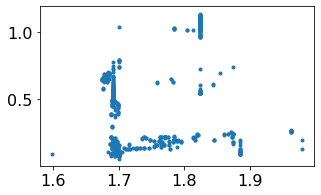

In [10]:
plt.figure(figsize=(13,3))
plt.subplot(131); plt.plot(X['L1:RG2:SC2:HZ:CurrentAO'],Y,'.'); 
plt.tight_layout()

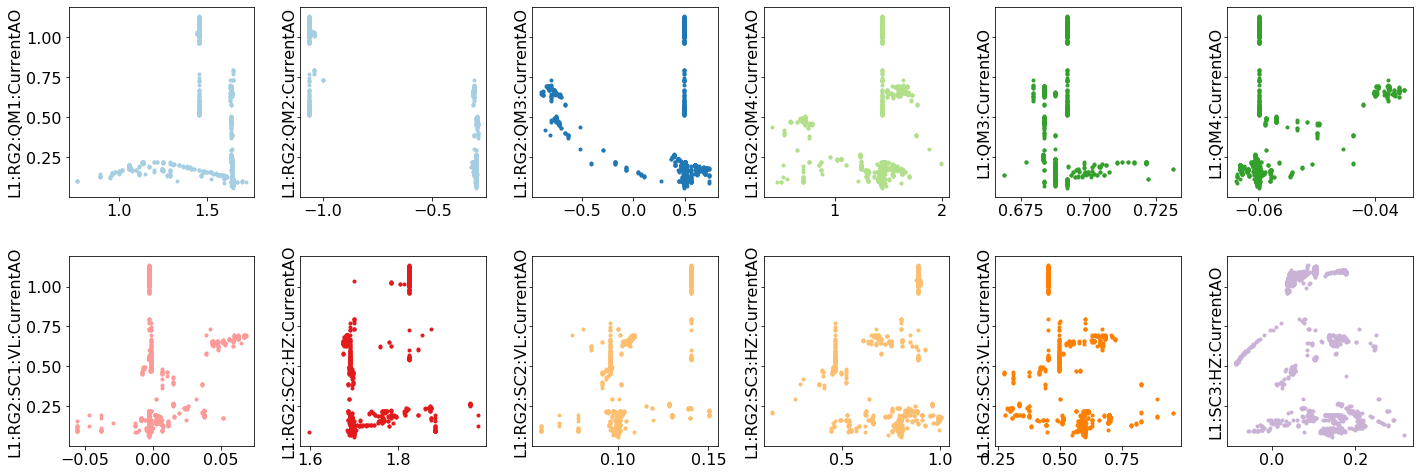

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=6, sharex=False, sharey=True,figsize=(20,7))

for i, ax in enumerate(axes.flatten()):
#     print(X.iloc[:,i])
    ax.plot(X.iloc[:,i], Y,'.', color=plt.cm.Paired(i/16.))
    ax.set_ylabel(X.keys()[i])

# #     plt.subplot(str(44,fsencode(i+1))); plt.plot(X[key],Y,'.');
# # plt.subplot(132); plt.plot(X['L1:SC3:VL:CurrentAO'],Y,'.');
# # plt.subplot(133); plt.plot(X['L1:SC4:VL:CurrentAO'],Y,'.');
plt.tight_layout()
plt.show()



# Final dataset

*Cut on chosen PVs which were actually scanned*

In [12]:
tstd=X.std(axis=0)
Q=(tstd>0.001) & (tstd<1)
print(sum(Q),'PVs were scanned:')
print(tstd[Q==True]);

16 PVs were scanned:
L1:RG2:QM1:CurrentAO       0.105130
L1:RG2:QM2:CurrentAO       0.297438
L1:RG2:QM3:CurrentAO       0.312212
L1:RG2:QM4:CurrentAO       0.154234
L1:QM3:CurrentAO           0.003649
L1:QM4:CurrentAO           0.004020
L1:RG2:SC1:VL:CurrentAO    0.011663
L1:RG2:SC2:HZ:CurrentAO    0.050730
L1:RG2:SC2:VL:CurrentAO    0.016639
L1:RG2:SC3:HZ:CurrentAO    0.107435
L1:RG2:SC3:VL:CurrentAO    0.068461
L1:SC3:HZ:CurrentAO        0.049334
L1:SC3:VL:CurrentAO        0.014016
L1:QM5:CurrentAO           0.033368
L1:SC4:HZ:CurrentAO        0.084264
L1:SC4:VL:CurrentAO        0.037000
dtype: float64


0.05743162393235027
Final Y_f.shape= (4179,)
Final X_f.shape= (4179, 16)


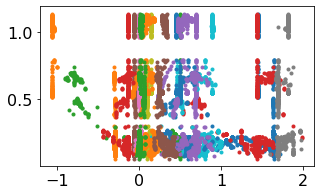

In [13]:
# Final X,Y:
Y_f=Y
print(Y_f.min())
#Y_f=Y
#remove Y<0.0001 data
X_f=X.loc[:,np.array(Q)]#.iloc[sub]
X_f=X_f[Y_f>0]
Y_f=Y_f[Y_f>0]
#10/31/2019 -- remove the filter 0.0001
print('Final Y_f.shape=',Y_f.shape)
print('Final X_f.shape=',X_f.shape)
plt.figure(figsize=(13,3))
plt.subplot(131); plt.plot(X_f,Y_f,'.'); 
plt.tight_layout()

In [14]:
from tfgp_trainer import tfgp_trainer

#Xin=X_f[Y_f>0]
#yin=Y_f[Y_f>0]
Xin=X_f
yin=Y_f
Niter = 2000

t0 = time.time()

tfgp2D = tfgp_trainer(Xin, yin)
#     tfgp2D.jitter=1e-6
tfgp2D.train(lr=0.005, niter=Niter,tol=1e-4,kernel=['rbf','matern32','matern52'][0],gradient_clipping=0,monitor_period=None) # pts by pts matrix inversion
print(np.array(tfgp2D.results['logLikelihood'])/len(yin))
print ('RBF took ', time.time()-t0,' seconds')
t0=time.time()
print(tfgp2D.get_result()['logLikelihood'],tfgp2D.get_result(False)['logLikelihood'])

ll=tfgp2D.results['logLikelihood']
likelihood=np.exp(ll)
amp_param=tfgp2D.results['alpha']
noise_param_variance=(tfgp2D.results['noise'])
length_scale_param=tfgp2D.results['lengthscales']
ls=length_scale_param[-1]
# plt.hist(ls,30); plt.show()
print('length_scale_param',ls)
print('noise_param_variance',noise_param_variance[-1][0])
print('amp',amp_param[-1][0])


tfgp2D_m32 = tfgp_trainer(Xin, yin)
#     tfgp2D.jitter=1e-6
tfgp2D_m32.train(lr=0.005, niter=Niter,tol=1e-4,kernel=['rbf','matern32','matern52'][1],gradient_clipping=0,monitor_period=None) # pts by pts matrix inversion
print(np.array(tfgp2D_m32.results['logLikelihood'])/len(yin))
print ('matern32 took ', time.time()-t0,' seconds')
t0=time.time()
print(tfgp2D_m32.get_result()['logLikelihood'],tfgp2D_m32.get_result(False)['logLikelihood'])

ll=tfgp2D_m32.results['logLikelihood']
likelihood=np.exp(ll)
amp_param=tfgp2D_m32.results['alpha']
noise_param_variance=(tfgp2D_m32.results['noise'])
length_scale_param=tfgp2D_m32.results['lengthscales']
ls=length_scale_param[-1]
# plt.hist(ls,30); plt.show()
print('length_scale_param',ls)
print('noise_param_variance',noise_param_variance[-1][0])
print('amp',amp_param[-1][0])


tfgp2D_m52 = tfgp_trainer(Xin, yin)
#     tfgp2D.jitter=1e-6
tfgp2D_m52.train(lr=0.005, niter=Niter,tol=1e-4,kernel=['rbf','matern32','matern52'][2],gradient_clipping=0,monitor_period=None) # pts by pts matrix inversion
print(np.array(tfgp2D_m52.results['logLikelihood'])/len(yin))
print ('matern52 took ', time.time()-t0,' seconds')
t0=time.time()

print(tfgp2D_m52.get_result()['logLikelihood'],tfgp2D_m52.get_result(False)['logLikelihood'])

ll=tfgp2D_m52.results['logLikelihood']
likelihood=np.exp(ll)
amp_param=tfgp2D_m52.results['alpha']
noise_param_variance=(tfgp2D_m52.results['noise'])
length_scale_param=tfgp2D_m52.results['lengthscales']
ls=length_scale_param[-1]
# plt.hist(ls,30); plt.show()
print('length_scale_param',ls)
print('noise_param_variance',noise_param_variance[-1][0])
print('amp',amp_param[-1][0])


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


100% (2000 of 2000) |####################| Elapsed Time: 0:11:37 Time:  0:11:37
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in exp


[0.19490531 0.19738477 0.19986344 ... 1.53752992 1.53752995 1.53752998]
RBF took  700.998605966568  seconds
6425.337772980465 6425.337772980465
length_scale_param [ 1.13256775  0.48333265  1.70614235 41.48879766 21.17218747 12.61112527
  0.54264309  2.24153238 20.99308566  2.78730295  3.54672684  0.35362253
  2.63808224  2.58535413  2.65573884  0.09535812]
noise_param_variance 0.0024810606073421685
amp 0.22864764163570153


100% (2000 of 2000) |####################| Elapsed Time: 0:11:56 Time:  0:11:56
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: overflow encountered in exp


[0.18673217 0.18924315 0.19175345 ... 1.53638556 1.53638564 1.53638571]
matern32 took  716.7382249832153  seconds
6420.555894838981 6420.555894838981
length_scale_param [ 2.73898512  1.16613519  3.20442241 53.30132235 28.35181392 17.39686164
  1.32598458  4.5892034  21.86064995  7.24122742  7.648172    0.93777218
  4.2339577   5.64668842  3.06271112  0.32314195]
noise_param_variance 0.002475190157129206
amp 0.3474332987868768


100% (2000 of 2000) |####################| Elapsed Time: 0:12:12 Time:  0:12:12


[0.19092493 0.19342395 0.19592224 ... 1.53684715 1.5368472  1.53684725]
matern52 took  732.8436844348907  seconds
6422.484644394137 6422.484644394137
length_scale_param [ 1.82745218  0.85081807  2.48537232 46.46390063 25.92940578 14.34186349
  0.84420442  3.41261987 22.28253054  4.80658144  4.88194591  0.59845472
  2.83080611  3.66927209  3.09715707  0.18549532]
noise_param_variance 0.0024820821345498444
amp 0.31224008327894215


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: RuntimeWarning: overflow encountered in exp


In [16]:
print(tfgp2D.get_result()['logLikelihood'],tfgp2D.get_result(False)['logLikelihood'])

ll=tfgp2D.results['logLikelihood']
likelihood=np.exp(ll)
amp_param=tfgp2D.results['alpha']
noise_param_variance=(tfgp2D.results['noise'])
length_scale_param=tfgp2D.results['lengthscales']
gradients=tfgp2D.results['gradients']
ls_grad=np.array([a[2][0] for a in gradients])
Parabola_vals=tfgp2D.Parabola_approx(amp_param[-1][0], noise_param_variance[-1][0], length_scale_param[-1], ll[-1], gradients[-1])


plt.figure(figsize=(20,8));
plt.subplot(232); plt.plot(ll); plt.xlabel('step'); plt.ylabel('log likelihood')
plt.subplot(231); plt.plot(np.array(ll)/len(yin)); plt.xlabel('step'); plt.ylabel('log likelihood / npts')
plt.subplot(233); plt.plot(amp_param); plt.xlabel('step'); plt.ylabel('amp param');
plt.subplot(234); plt.plot(noise_param_variance); plt.xlabel('step'); plt.ylabel('noise param variance');
plt.subplot(235); plt.plot(length_scale_param); plt.xlabel('step'); plt.ylabel('lengthscales');
plt.subplot(236); plt.plot(ls_grad); plt.xlabel('step'); plt.ylabel('length scale gradient');

ls=length_scale_param[-1]
# plt.hist(ls,30); plt.show()
print('length_scale_param',ls)
print('noise_param_variance',noise_param_variance[-1][0])
print('amp',amp_param[-1][0])

4462.45045224798 4462.45045224798



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


ResourceExhaustedError: ignored

5427.344168662314 5427.344168662314



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.




length_scale_param [ 0.83853285  0.40720854  1.41944298  8.2454312   0.43448385  0.81999656
  1.45599048  1.05916947  0.56073965 13.22223281 15.01524653  0.55398199
  0.49313177  1.37838028  0.63297581  0.37976785]
noise_param_variance 0.004014558861905971
amp 0.07940691063873442


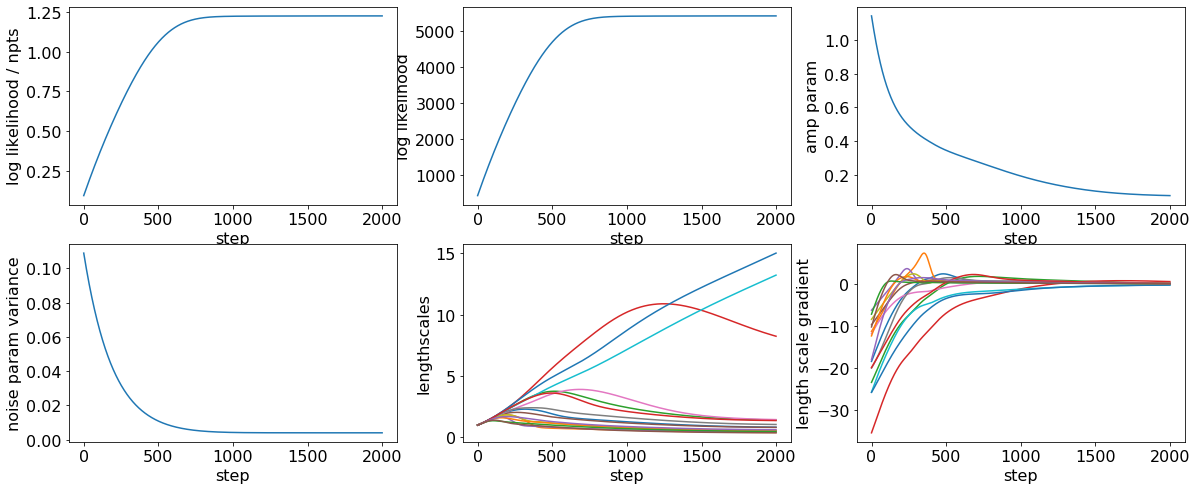

In [28]:
print(tfgp2D_m32.get_result()['logLikelihood'],tfgp2D_m32.get_result(False)['logLikelihood'])

ll=tfgp2D_m32.results['logLikelihood']
likelihood=np.exp(ll)
amp_param=tfgp2D_m32.results['alpha']
noise_param_variance=(tfgp2D_m32.results['noise'])
length_scale_param=tfgp2D_m32.results['lengthscales']
gradients=tfgp2D_m32.results['gradients']
ls_grad=np.array([a[2][0] for a in gradients])
Parabola_vals=tfgp2D_m32.Parabola_approx(amp_param[-1][0], noise_param_variance[-1][0], length_scale_param[-1], ll[-1], gradients[-1])


plt.figure(figsize=(20,8));
plt.subplot(232); plt.plot(ll); plt.xlabel('step'); plt.ylabel('log likelihood')
plt.subplot(231); plt.plot(np.array(ll)/len(yin)); plt.xlabel('step'); plt.ylabel('log likelihood / npts')
plt.subplot(233); plt.plot(amp_param); plt.xlabel('step'); plt.ylabel('amp param');
plt.subplot(234); plt.plot(noise_param_variance); plt.xlabel('step'); plt.ylabel('noise param variance');
plt.subplot(235); plt.plot(length_scale_param); plt.xlabel('step'); plt.ylabel('lengthscales');
plt.subplot(236); plt.plot(ls_grad); plt.xlabel('step'); plt.ylabel('length scale gradient');

ls=length_scale_param[-1]
# plt.hist(ls,30); plt.show()
print('length_scale_param',ls)
print('noise_param_variance',noise_param_variance[-1][0])
print('amp',amp_param[-1][0])

5423.420947629655 5423.420947629655


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


length_scale_param [ 0.61757356  0.31387079  1.04668222  6.18511423  0.3344641   0.61586292
  1.01026489  0.79172582  0.42758114  9.70398238 11.42190251  0.39374697
  0.369767    1.03753952  0.4223535   0.28690526]
noise_param_variance 0.004040146915048885
amp 0.0675485046070075


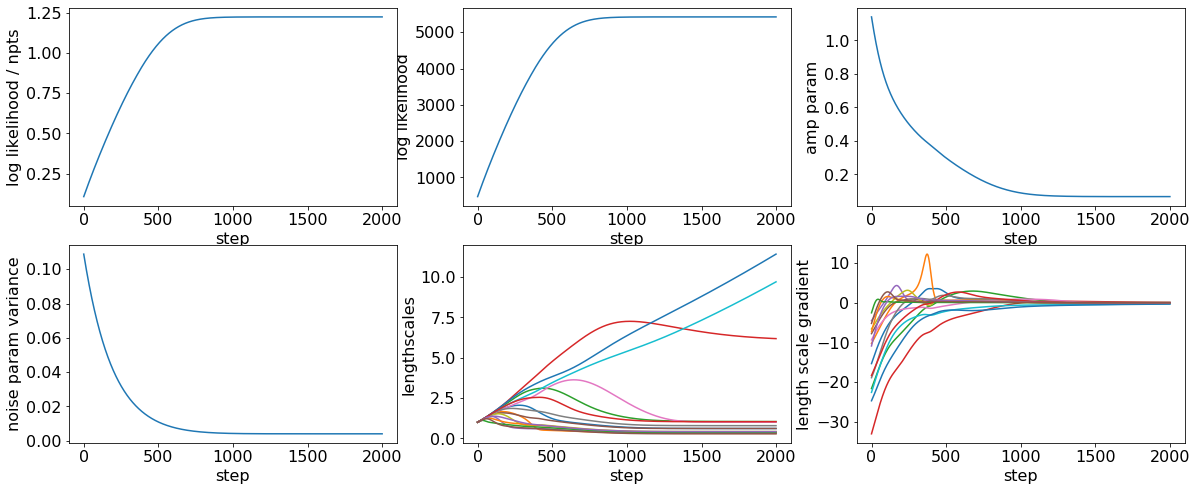

In [34]:
print(tfgp2D_m52.get_result()['logLikelihood'],tfgp2D_m52.get_result(False)['logLikelihood'])

ll=tfgp2D_m52.results['logLikelihood']
likelihood=np.exp(ll)
amp_param=tfgp2D_m52.results['alpha']
noise_param_variance=(tfgp2D_m52.results['noise'])
length_scale_param=tfgp2D_m52.results['lengthscales']
gradients=tfgp2D_m52.results['gradients']
ls_grad=np.array([a[2][0] for a in gradients])
Parabola_vals=tfgp2D_m52.Parabola_approx(amp_param[-1][0], noise_param_variance[-1][0], length_scale_param[-1], ll[-1], gradients[-1])


plt.figure(figsize=(20,8));
plt.subplot(232); plt.plot(ll); plt.xlabel('step'); plt.ylabel('log likelihood')
plt.subplot(231); plt.plot(np.array(ll)/len(yin)); plt.xlabel('step'); plt.ylabel('log likelihood / npts')
plt.subplot(233); plt.plot(amp_param); plt.xlabel('step'); plt.ylabel('amp param');
plt.subplot(234); plt.plot(noise_param_variance); plt.xlabel('step'); plt.ylabel('noise param variance');
plt.subplot(235); plt.plot(length_scale_param); plt.xlabel('step'); plt.ylabel('lengthscales');
plt.subplot(236); plt.plot(ls_grad); plt.xlabel('step'); plt.ylabel('length scale gradient');

ls=length_scale_param[-1]
# plt.hist(ls,30); plt.show()
print('length_scale_param',ls)
print('noise_param_variance',noise_param_variance[-1][0])
print('amp',amp_param[-1][0])

5423.420947629655 5423.420947629655


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


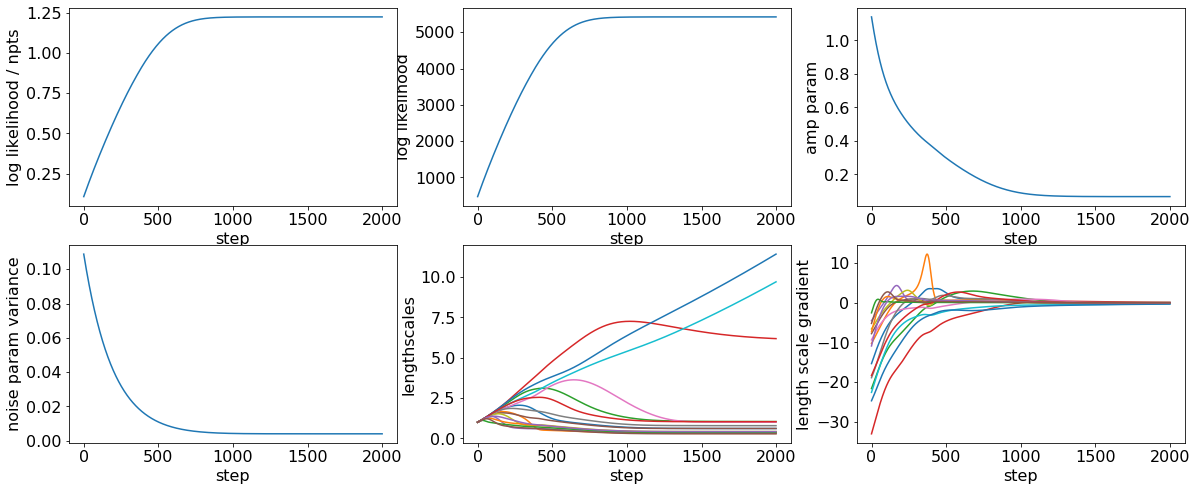

In [31]:
print(tfgp2D_m52.get_result()['logLikelihood'],tfgp2D_m52.get_result(False)['logLikelihood'])

ll=tfgp2D_m52.results['logLikelihood']
likelihood=np.exp(ll)
amp_param=tfgp2D_m52.results['alpha']
noise_param_variance=(tfgp2D_m52.results['noise'])
length_scale_param=tfgp2D_m52.results['lengthscales']
gradients=tfgp2D_m52.results['gradients']
ls_grad=np.array([a[2][0] for a in gradients])
Parabola_vals=tfgp2D_m52.Parabola_approx(amp_param[-1][0], noise_param_variance[-1][0], length_scale_param[-1], ll[-1], gradients[-1])


plt.figure(figsize=(20,8));
plt.subplot(232); plt.plot(ll); plt.xlabel('step'); plt.ylabel('log likelihood')
plt.subplot(231); plt.plot(np.array(ll)/len(yin)); plt.xlabel('step'); plt.ylabel('log likelihood / npts')
plt.subplot(233); plt.plot(amp_param); plt.xlabel('step'); plt.ylabel('amp param');
plt.subplot(234); plt.plot(noise_param_variance); plt.xlabel('step'); plt.ylabel('noise param variance');
plt.subplot(235); plt.plot(length_scale_param); plt.xlabel('step'); plt.ylabel('lengthscales');
plt.subplot(236); plt.plot(ls_grad); plt.xlabel('step'); plt.ylabel('length scale gradient');

ls=length_scale_param[-1]
# plt.hist(ls,30); plt.show()

In [14]:
from tfgp_trainer import tfgp_trainer

#Xin=X_f[Y_f>0]
#yin=Y_f[Y_f>0]
Xin=X_f
yin=Y_f
Niter = 2000

t0 = time.time()

tfgp2D = tfgp_trainer(Xin, yin)
#     tfgp2D.jitter=1e-6

tfgp2D.train_corr(lr=0.005, niter=Niter,
             optimizer=[tf.compat.v1.train.AdamOptimizer, tf.compat.v1.train.GradientDescentOptimizer, tf.compat.v1.train.RMSPropOptimizer][0],
             gradient_clipping=0,
             kernel=['rbf','matern32','matern52'][0],
             correlations = True,
             offset = False,
             monitor_period=None) # pts by pts matrix inversion

corr_param=tfgp2D.results['corr']

precision_matrix=tfgp2D.results['precision_matrix']

plt.subplot(232); plt.plot(corr_param); plt.xlabel('step'); plt.ylabel('corr param')

print('corr_param',corr[-1])

print('precision_matrix',precision_matrix[-1])
print ('RBF took ', time.time()-t0,' seconds')



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


100% (2000 of 2000) |####################| Elapsed Time: 0:00:09 Time:  0:00:09


InvalidArgumentError: ignored

precision_matrix [[ 16.71385489   0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.        ]
 [  0.          19.99627633   0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.        ]
 [  0.           0.           4.76090229   0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.        ]
 [  0.           0.           0.           0.95711848   0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.        ]
 [  0.           0.           0.           0.          32.49940259
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.        ]
 [  0.    

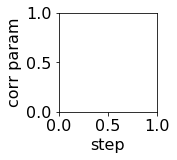

In [26]:
precision_matrix=tfgp2D.results['precision_matrix']

plt.subplot(232);plt.xlabel('step'); plt.ylabel('corr param')



print('precision_matrix',precision_matrix[-1])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  




length_scale_param [0.24460295 0.22362762 0.45830581 1.02215592 0.17541322 0.2629256
 0.40156738 0.64550455 0.38507488 0.94442535 0.59205422 0.11245807
 0.13006519 0.5639242  0.09520972 0.14503264]
noise_param_variance 0.00020739573342717896
amp 0.13836610558834272


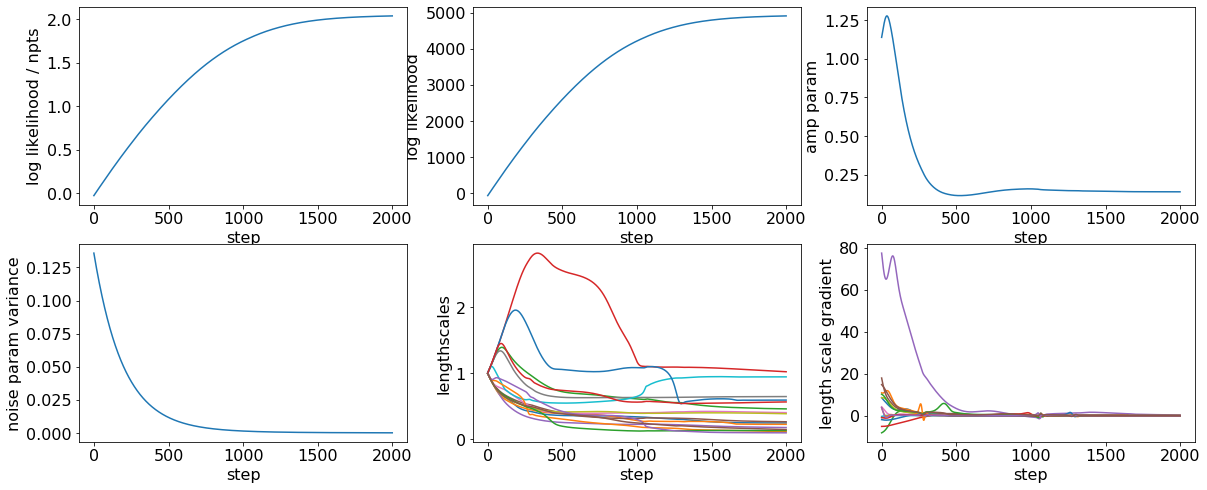

In [27]:
ll=tfgp2D.results['logLikelihood']
likelihood=np.exp(ll)
amp_param=tfgp2D.results['alpha']
noise_param_variance=(tfgp2D.results['noise'])
length_scale_param=tfgp2D.results['lengthscales']
gradients=tfgp2D.results['gradients']
ls_grad=np.array([a[2][0] for a in gradients])
Parabola_vals=tfgp2D.Parabola_approx(amp_param[-1][0], noise_param_variance[-1][0], length_scale_param[-1], ll[-1], gradients[-1])


plt.figure(figsize=(20,8));
plt.subplot(232); plt.plot(ll); plt.xlabel('step'); plt.ylabel('log likelihood')
plt.subplot(231); plt.plot(np.array(ll)/len(yin)); plt.xlabel('step'); plt.ylabel('log likelihood / npts')
plt.subplot(233); plt.plot(amp_param); plt.xlabel('step'); plt.ylabel('amp param');
plt.subplot(234); plt.plot(noise_param_variance); plt.xlabel('step'); plt.ylabel('noise param variance');
plt.subplot(235); plt.plot(length_scale_param); plt.xlabel('step'); plt.ylabel('lengthscales');
plt.subplot(236); plt.plot(ls_grad); plt.xlabel('step'); plt.ylabel('length scale gradient');

ls=length_scale_param[-1]
# plt.hist(ls,30); plt.show()
print('length_scale_param',ls)
print('noise_param_variance',noise_param_variance[-1][0])
print('amp',amp_param[-1][0])

# Run TFGP on single scan

In [0]:
from tfgp_trainer import tfgp_trainer

#Xin=X_f[Y_f>0]
#yin=Y_f[Y_f>0]
Xin=X_f
yin=Y_f
Niter = 2000

t0 = time.time()

tfgp2D = tfgp_trainer(Xin, yin)
#     tfgp2D.jitter=1e-6
tfgp2D.train(lr=0.005, niter=Niter,tol=1e-4,kernel=['rbf','matern32','matern52'][0],gradient_clipping=0,monitor_period=None) # pts by pts matrix inversion
print(np.array(tfgp2D.results['logLikelihood'])/len(yin))
print ('RBF took ', time.time()-t0,' seconds')
t0=time.time()

tfgp2D_m32 = tfgp_trainer(Xin, yin)
#     tfgp2D.jitter=1e-6
tfgp2D_m32.train(lr=0.005, niter=Niter,tol=1e-4,kernel=['rbf','matern32','matern52'][1],gradient_clipping=0,monitor_period=None) # pts by pts matrix inversion
print(np.array(tfgp2D_m32.results['logLikelihood'])/len(yin))
print ('matern32 took ', time.time()-t0,' seconds')
t0=time.time()

tfgp2D_m52 = tfgp_trainer(Xin, yin)
#     tfgp2D.jitter=1e-6
tfgp2D_m52.train(lr=0.005, niter=Niter,tol=1e-4,kernel=['rbf','matern32','matern52'][2],gradient_clipping=0,monitor_period=None) # pts by pts matrix inversion
print(np.array(tfgp2D_m52.results['logLikelihood'])/len(yin))
print ('matern52 took ', time.time()-t0,' seconds')
t0=time.time()



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


N/A% (0 of 2000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

434.38389777699 434.38389777699
length_scale_param [ 0.95203454  0.04201002  0.54792284  1.56473264 11.36910916  0.07681864
  1.17848694 10.85046135  0.87268506 12.07518341  1.01960077  8.01595708
  5.37104184 11.70160679  0.68258843  3.86393958]
noise_param_variance 0.0017766302014342514
amp 0.04212045023918619


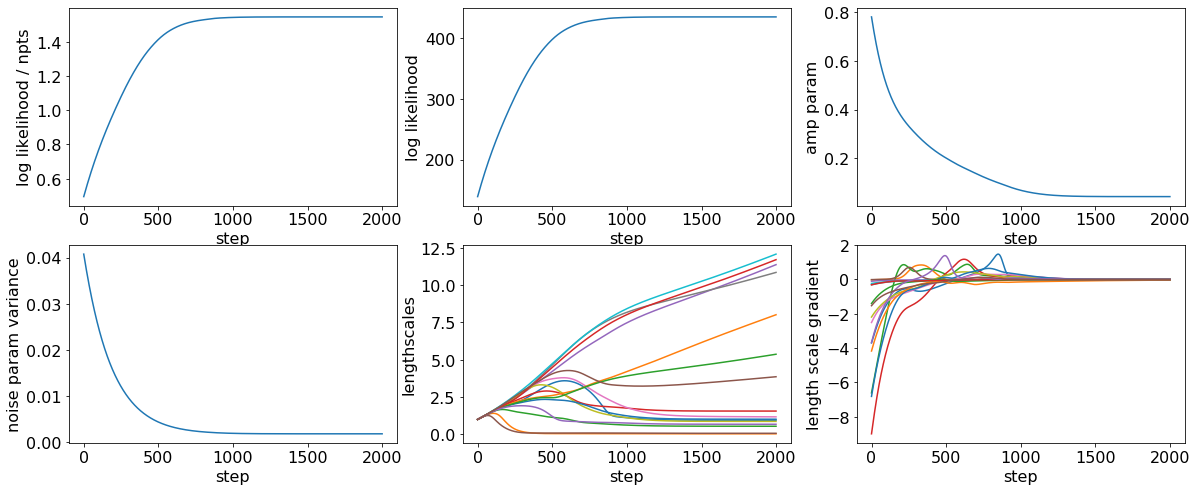

In [27]:
from tfgp_trainer import tfgp_trainer

Xin=X_f
yin=Y_f
Niter = 2000

t0 = time.time()

#tfgp2D = tfgp_trainer(Xin, yin)
#    tfgp2D.jitter=1e-6
#tfgp2D.train(lr=0.005, niter=Niter,tol=1e-4,kernel=['rbf','matern32','matern52'][1],gradient_clipping=0,monitor_period=None) # pts by pts matrix inversion


print(tfgp2D.get_result()['logLikelihood'],tfgp2D.get_result(False)['logLikelihood'])


ll=tfgp2D.results['logLikelihood']
likelihood=np.exp(ll)
amp_param=tfgp2D.results['alpha']
noise_param_variance=(tfgp2D.results['noise'])
length_scale_param=tfgp2D.results['lengthscales']
gradients=tfgp2D.results['gradients']
ls_grad=np.array([a[2][0] for a in gradients])
Parabola_vals=tfgp2D.Parabola_approx(amp_param[-1][0], noise_param_variance[-1][0], length_scale_param[-1], ll[-1], gradients[-1])


plt.figure(figsize=(20,8));
plt.subplot(232); plt.plot(ll); plt.xlabel('step'); plt.ylabel('log likelihood')
plt.subplot(231); plt.plot(np.array(ll)/len(yin)); plt.xlabel('step'); plt.ylabel('log likelihood / npts')
plt.subplot(233); plt.plot(amp_param); plt.xlabel('step'); plt.ylabel('amp param');
plt.subplot(234); plt.plot(noise_param_variance); plt.xlabel('step'); plt.ylabel('noise param variance');
plt.subplot(235); plt.plot(length_scale_param); plt.xlabel('step'); plt.ylabel('lengthscales');
plt.subplot(236); plt.plot(ls_grad); plt.xlabel('step'); plt.ylabel('length scale gradient');

ls=length_scale_param[-1]
# plt.hist(ls,30); plt.show()
print('length_scale_param',ls)
print('noise_param_variance',noise_param_variance[-1][0])
print('amp',amp_param[-1][0])
#print ('took ', time.time()-t0,' seconds')

In [102]:
ls=length_scale_param[-1]
# plt.hist(ls,30); plt.show()
print('length_scale_param',ls)
print('noise_param_variance',noise_param_variance[-1][0])
print('amp',amp_param[-1][0])

length_scale_param [0.33288468 0.25384964 0.44732893 4.36670369 0.284272   0.38187369
 0.33507802 0.57132642 0.22516421 0.72504281 0.92558641 0.2516231
 0.2894494  1.3894101  0.52856522 0.29348572]
noise_param_variance 0.000495287530734684
amp 0.09861835988613082


431.29218035947315 431.29218035947315



length_scale_param [ 2.98112734  0.12440132  1.52040196  4.18895802 19.20621013  0.26100234
  3.69197661 20.23853172  2.6043351  22.4034807   2.73263662 17.22841418
  8.0875261  21.11675922  2.12811177  5.9372974 ]
noise_param_variance 0.0017695519538575629
amp 0.11894402996537502


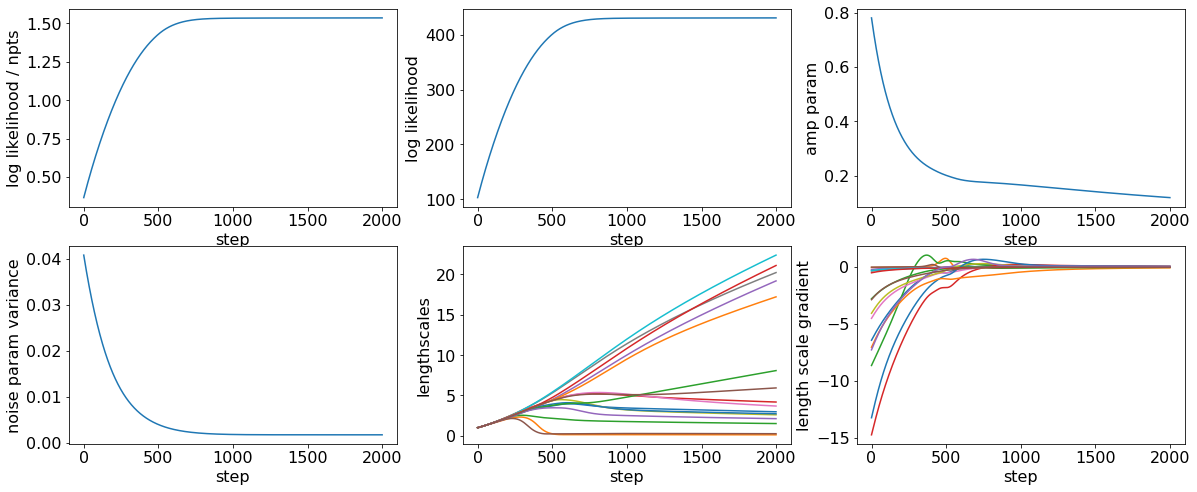

In [26]:

print(tfgp2D_m32.get_result()['logLikelihood'],tfgp2D_m32.get_result(False)['logLikelihood'])

ll=tfgp2D_m32.results['logLikelihood']
likelihood=np.exp(ll)
amp_param=tfgp2D_m32.results['alpha']
noise_param_variance=(tfgp2D_m32.results['noise'])
length_scale_param=tfgp2D_m32.results['lengthscales']
gradients=tfgp2D_m32.results['gradients']
ls_grad=np.array([a[2][0] for a in gradients])
Parabola_vals=tfgp2D_m32.Parabola_approx(amp_param[-1][0], noise_param_variance[-1][0], length_scale_param[-1], ll[-1], gradients[-1])


plt.figure(figsize=(20,8));
plt.subplot(232); plt.plot(ll); plt.xlabel('step'); plt.ylabel('log likelihood')
plt.subplot(231); plt.plot(np.array(ll)/len(yin)); plt.xlabel('step'); plt.ylabel('log likelihood / npts')
plt.subplot(233); plt.plot(amp_param); plt.xlabel('step'); plt.ylabel('amp param');
plt.subplot(234); plt.plot(noise_param_variance); plt.xlabel('step'); plt.ylabel('noise param variance');
plt.subplot(235); plt.plot(length_scale_param); plt.xlabel('step'); plt.ylabel('lengthscales');
plt.subplot(236); plt.plot(ls_grad); plt.xlabel('step'); plt.ylabel('length scale gradient');

ls=length_scale_param[-1]
# plt.hist(ls,30); plt.show()
print('length_scale_param',ls)
print('noise_param_variance',noise_param_variance[-1][0])
print('amp',amp_param[-1][0])


433.390800900817 433.390800900817
length_scale_param [ 1.60334478  0.06944773  0.90576384  2.47603468 15.46304192  0.13846108
  2.00828859 15.5516765   1.40619315 17.11943206  1.53582968 12.07984229
  6.17435051 16.13842023  1.15094694  4.56071731]
noise_param_variance 0.0017700251609747853
amp 0.06469589125381202


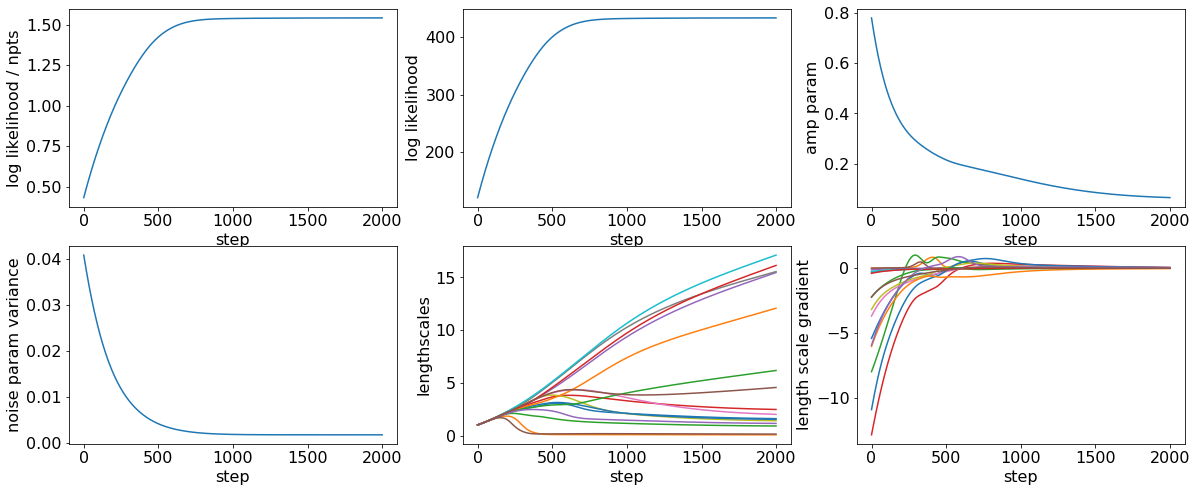

In [28]:
print(tfgp2D_m52.get_result()['logLikelihood'],tfgp2D_m52.get_result(False)['logLikelihood'])

ll=tfgp2D_m52.results['logLikelihood']
likelihood=np.exp(ll)
amp_param=tfgp2D_m52.results['alpha']
noise_param_variance=(tfgp2D_m52.results['noise'])
length_scale_param=tfgp2D_m52.results['lengthscales']
gradients=tfgp2D_m52.results['gradients']
ls_grad=np.array([a[2][0] for a in gradients])
Parabola_vals=tfgp2D_m52.Parabola_approx(amp_param[-1][0], noise_param_variance[-1][0], length_scale_param[-1], ll[-1], gradients[-1])


plt.figure(figsize=(20,8));
plt.subplot(232); plt.plot(ll); plt.xlabel('step'); plt.ylabel('log likelihood')
plt.subplot(231); plt.plot(np.array(ll)/len(yin)); plt.xlabel('step'); plt.ylabel('log likelihood / npts')
plt.subplot(233); plt.plot(amp_param); plt.xlabel('step'); plt.ylabel('amp param');
plt.subplot(234); plt.plot(noise_param_variance); plt.xlabel('step'); plt.ylabel('noise param variance');
plt.subplot(235); plt.plot(length_scale_param); plt.xlabel('step'); plt.ylabel('lengthscales');
plt.subplot(236); plt.plot(ls_grad); plt.xlabel('step'); plt.ylabel('length scale gradient');

ls=length_scale_param[-1]
# plt.hist(ls,30); plt.show()
print('length_scale_param',ls)
print('noise_param_variance',noise_param_variance[-1][0])
print('amp',amp_param[-1][0])

In [46]:
 # calculte measures for each index
pres=pd.DataFrame(columns=X.keys()).astype('object')
Zscore=pd.DataFrame(columns=X.keys()).astype('object')
rel_uncer=pd.DataFrame(columns=X.keys()).astype('object')
for ind in X.index: 
    print(ind)
    pres.loc[ind,:]=(width_calc(Parabola_vals,ind))**(-2) # Check absolute uncertainty in the parameter.
    Zscore.loc[ind,:]=(ls.loc[ind]-Xp_calc(Parabola_vals,ind))/width_calc(Parabola_vals,ind); #convergence check
    rel_uncer.loc[ind,:]=width_calc(Parabola_vals,ind)/ls.loc[ind] # Check relative uncertainty in the parameter.


0


AttributeError: ignored

In [0]:
keyplt
Zscore=(ls.loc[keyplt]-Xp_calc(keyplt))/width_calc(keyplt); #convergence check
# plt.figure(figsize=(10,4))
# plt.subplot(131);plt.hist(Zscore,30);plt.title('Zscores of '+str(keyplt))
# plt.subplot(132);plt.hist(Zscore[Zscore<100],30); plt.title('Zscores<100'); 
# plt.subplot(133);plt.hist(Zscore[np.abs(Zscore)<2],30); plt.title('Zscores<2'); plt.show()

In [0]:
# # Cut some points
# rel_uncer=np.array((width_calc(keyplt))/ls_opt_tot.loc[keyplt])
# idx = ((rel_uncer)<0.5) # Check relative uncertainty in the parameter.
# idx *= (pres>3) # Check absolute uncertainty in the parameter.
# idx *= np.abs(ll_opt_tot/nts-1)<1 # Check it is a good fit - likelihood is on ~1.
# idx *= np.abs(Zscore)<2 # Check if the thing converged.

# plt.figure(figsize=(20,9))
# plt.subplot(231);plt.scatter(Eel[idx],ls_opt_tot.loc[keyplt][idx],c=FEL[idx]); plt.xlabel('Electron energy'); plt.ylabel(str(keyplt)); plt.title('Lengthscales of '+str(keyplt)) 
# clb = plt.colorbar(); clb.ax.set_title('FEL energy'); 
# plt.subplot(232);plt.scatter(Eel[idx],ls_opt_tot.loc[keyplt][idx],c=np.log(pres[idx])); plt.xlabel('Electron energy'); plt.ylabel(str(keyplt)); plt.title('Lengthscales of '+str(keyplt))
# clb = plt.colorbar(); clb.ax.set_title('ls LOG width**-2'); 
# ls_opt_PV=np.array(ls_opt_tot.loc[keyplt][idx])
# plt.subplot(233);plt.hist(ls_opt_PV,30);plt.title('lengthscales of '+str(keyplt))
# plt.subplot(234);plt.scatter(Eel[idx],ls_opt_tot.loc[keyplt][idx],c=ll_opt_tot[idx]/np.array(nts)[idx]); plt.xlabel('Electron energy'); 
# plt.ylabel(str(keyplt)); plt.title('Lengthscales of '+str(keyplt))
# clb = plt.colorbar(); clb.ax.set_title('ll/nts'); 
# plt.subplot(235);plt.scatter(Eel[idx],ls_opt_tot.loc[keyplt][idx],c=(width_calc(keyplt)[idx])); plt.xlabel('Electron energy'); plt.ylabel(str(keyplt)); plt.title('Lengthscales of '+str(keyplt))
# clb = plt.colorbar(); clb.ax.set_title('ls width'); 
# plt.subplot(236);plt.hist(width_calc(keyplt)[idx],30);plt.title('Widths of '+str(keyplt)); plt.show()

In [0]:
# #plot parabolas
# x=np.linspace(-3,25,300)
# tot=0
# for i in range(11): # or for all -  range(np.size(ls_opt_tot.loc[keyplt]))
#     if np.isnan(Parabola_vals_tot.loc[keyplt][ts[i]]).all():
#         pass
#     else:
#         tot=tot+1
#         ymax=np.max(np.exp(func(x,Parabola_vals_tot.loc[keyplt])[i]))
#         plt.plot(x,np.exp(func(x,Parabola_vals_tot.loc[keyplt])[i])/ymax)
#         #,label=('ls= '+str(ls_opt[i])+'\nx_p= '+str(Parabola_vals[i+1][3])+'\nsig_p= '+str(Parabola_vals[i+1][4])));
# #         plt.plot((-Parabola_vals_tot.loc[keyplt][ts[i]][4], Parabola_vals_tot.loc[keyplt][ts[i]][4]), (0.5,0.5), 'k-');
# #         plt.legend(); plt.axvline(x=0,color='r');plt.xlabel('lengthscales'); plt.ylabel('liklihood'); plt.ylim(0,1);plt.show()
# print(tot, ' parabolas')

# Evaluate log liklihood for scan with ls=1

In [0]:
l0=np.array(ls_opt_tot.loc[PV_select_s.keys()[0]][ix])[0]
l1 = np.array(ls_opt_tot.loc[PV_select_s.keys()[1]][ix])[0]
l2=np.array(ls_opt_tot.loc[PV_select_s.keys()[2]][ix])[0]
l3=np.array(ls_opt_tot.loc[PV_select_s.keys()[3]][ix])[0]

In [0]:
lss=np.linspace(0.05,3.8,21)
out_ls_0=np.array([tfgp2D.eval(amp_opt_tot[ix][0], noise_opt_tot[ix][0],[ls,l1,l2,l3]) for ls in lss])
out_ls_1=np.array([tfgp2D.eval(amp_opt_tot[ix][0], noise_opt_tot[ix][0],[l0,ls,l2,l3]) for ls in lss])

lss2=np.linspace(3.5,8,11)
out_ls_2=np.array([tfgp2D.eval(amp_opt_tot[ix][0], noise_opt_tot[ix][0],[l0,l1,ls,l3]) for ls in lss2])
out_ls_3=np.array([tfgp2D.eval(amp_opt_tot[ix][0], noise_opt_tot[ix][0],[l0,l1,l2,ls]) for ls in lss2])

In [0]:
lik_ls_0=out_ls_0[:,0].astype('float64')
lik_ls_1=out_ls_1[:,0].astype('float64')
lik_ls_2=out_ls_2[:,0].astype('float64')
lik_ls_3=out_ls_3[:,0].astype('float64')

In [0]:
# def pltli(lss,lik_ls,i):
#     l00 = np.array(ls_opt_tot.loc[PV_select_s.keys()[i]][ix])[0]
#     plt.plot(lss, np.exp(np.array(lik_ls/X_f.shape[0])));
#     plt.axvline(x=l00,color='r');
#     plt.xlabel('Lengthscales [kG]')
#     plt.ylabel('Likelihood'); 
#     plt.title(PV_select_s.keys()[i])
#     plt.ylim(0,6)
    
# plt.figure(figsize=(25,5))
# plt.subplot(141); pltli(lss, lik_ls_0, 0)
# plt.subplot(142); pltli(lss, lik_ls_1, 1)
# plt.subplot(143); pltli(lss2, lik_ls_2, 2)
# plt.subplot(144); pltli(lss2, lik_ls_3, 3);


# # filename_prefix = 'marginal_likelihod'
# # plt.savefig('Results/'+filename_prefix+'.pdf', bbox_inches='tight');  
# # plt.savefig('Results/'+filename_prefix+'.png', bbox_inches='tight'); 

# Pegasus hyper parameters training from simulation

In [0]:
import scipy.io as sio

Xsim = sio.loadmat('Pegasus_ML/parameterScan3.mat')['finalParMat']
Xsim_keys=['quad1', 'quad2','quad3' ,'sigma_xx' ,'sigma_xy', 'sigma_yy', 'e_n_x' ,' e_n_y']
Xsim=pd.DataFrame(Xsim,columns=Xsim_keys)
ysim=Xsim['sigma_yy' ]/Xsim['sigma_xx' ]
print(' Y.shape=',ysim.shape)
print(' X.shape=',Xsim.shape)
print(Xsim.keys())

In [0]:
Xsim.std()

In [0]:
idx = (Xsim['quad1'] > -4) & (Xsim['quad1']< -2) & (Xsim['quad2']>2) & (Xsim['quad3']>4)
np.sum(idx)

In [0]:
plt.figure(figsize=(13,3))
plt.subplot(131); plt.plot(Xsim['quad1'][idx],ysim[idx],'.'); plt.xlabel('quad1');
plt.subplot(132); plt.plot(Xsim['quad2'][idx],ysim[idx],'.'); plt.xlabel('quad2');
plt.subplot(133); plt.plot(Xsim['quad3'][idx],ysim[idx],'.'); plt.xlabel('quad3');
plt.tight_layout()
plt.figure(figsize=(13,3))
plt.subplot(131); plt.plot(Xsim['quad1'][idx],'.'); plt.ylabel('quad1');
plt.subplot(132); plt.plot(Xsim['quad2'][idx],'.'); plt.ylabel('quad2');
plt.subplot(133); plt.plot(Xsim['quad3'][idx],'.'); plt.ylabel('quad3');
plt.tight_layout()

In [0]:
from tfgp_trainer import tfgp_trainer

Xin=X_f
yin=Y_f
ndim_x=Xin.shape[1]

Niter = 2000

t0 = time.time()

tfgp2D = tfgp_trainer(Xin, yin)
#     tfgp2D.jitter=1e-6
tfgp2D.train(lr=0.005, niter=Niter,tol=1e-5,gradient_clipping=0,monitor_period=None) # pts by pts matrix inversion


print(tfgp2D.get_result()['logLikelihood'],tfgp2D.get_result(False)['logLikelihood'])

ll=tfgp2D.results['logLikelihood']
likelihood=np.exp(ll)
amp_param=tfgp2D.results['alpha']
noise_param_variance=(tfgp2D.results['noise'])
length_scale_param=tfgp2D.results['lengthscales']
gradients=tfgp2D.results['gradients']
ls_grad=np.array([a[2][0] for a in gradients])
Parabola_vals=tfgp2D.Parabola_approx(amp_param[-1][0], noise_param_variance[-1][0], length_scale_param[-1], ll[-1], gradients[-1])


plt.figure(figsize=(20,8));
plt.subplot(232); plt.plot(ll); plt.xlabel('step'); plt.ylabel('log likelihood')
plt.subplot(231); plt.plot(np.array(ll)/len(yin)); plt.xlabel('step'); plt.ylabel('log likelihood / npts')
plt.subplot(233); plt.plot(amp_param); plt.xlabel('step'); plt.ylabel('amp param');
plt.subplot(234); plt.plot(noise_param_variance); plt.xlabel('step'); plt.ylabel('noise param variance');
plt.subplot(235); plt.plot(length_scale_param); plt.xlabel('step'); plt.ylabel('lengthscales');
plt.subplot(236); plt.plot(ls_grad); plt.xlabel('step'); plt.ylabel('length scale gradient');


print ('took ', time.time()-t0,' seconds')

In [0]:
ls=length_scale_param[-1]
# plt.hist(ls,30); plt.show()
print('length_scale_param',ls)
print('noise_param_variance',noise_param_variance[-1][0])
print('amp',amp_param[-1][0])